## Univariate Statistics and the SME

Yesterday, we learned how to extract measures of spectral power from EEG signals. Today, we're going to extend that work by analyzing **how spectral power correlates with cognitive, behavioral, or physiological variables** of interest. This is the core of almost any analysis you'll carry out in the Computational Memory Lab. 

The statistical approach we'll use today will be mostly straightforward T-tests to assess differences between normal distributions of power values. In particular, we'll focus on the contrast between power during successfully-encoded versus forgotten words. You'll see this called the **Subsequent Memory Effect** (SME) in the literature. In general, you can take an SME-style approach to any physiological variable.  

The basic analysis scheme is as follows: 

1. Extract spectral power for all encoding events (e.g. wavelet transform)
2. Normalize spectral power for each experimental session
3. Use a 2-sample T-test to compare distributions of power between remembered and not-remembered items
4. *Optional:* Average results into time windows or frequency bands of interest. 
5. Repeat for each subject in the dataset.

Let's get to work!

In [1]:
from CMLLoad import CMLLoad

# Remember to update this to where your CMLExamples data is located.
load = CMLLoad('./CMLExamples')

# We load the dataframe for all sessions.
df = load.Index()

# Specify which subject and experiment we want
sub = 'R1111M'
exp = 'FR1'

# Select the dataframes for our subject and experiment.
df_select = df[(df['subject']==sub) & (df['experiment']==exp)]
# Pick the first session
df_sess = df_select.iloc[0]

# For first session...
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']


In [2]:
import numpy as np

# Instead of just looking at session 1,
# we want to analyze data from all sessions.
# To do that, we'll use a for loop.

recalled = []  #for storing encoding success
sess_pows = []  #for storing our computed spectral powers

# Iterate over the DataFrame rows for each session
for df_sess in df_select.itertuples():
    # Load this session's events, and select word events.
    evs = load.Load(df_sess, 'events')
    word_evs = evs[evs['type']=='WORD']

    # Grab the events as a PTSA object.
    buf = 1000  #to remove edge effects during wavelet convolution
    eeg_ptsa = load.LoadPTSA(df_sess, -buf, buf+1600+buf)
    # Select the word events.
    eeg_ptsa = eeg_ptsa[word_evs.index]
    
    from ptsa.data.filters import ButterworthFilter
    from ptsa.data.filters import MorletWaveletFilter
    
    sess = df_sess._asdict()['session']
    sr = eeg_ptsa.samplerate
    
    # Filter out line noise.
    freq_range = [58., 62.]
    b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
    eeg_filtered = b_filter.filter()
    
    # Get spectral power.
    myfreqs = np.logspace(np.log10(3), np.log10(170), 10)  #let's start with 3-170 Hz, 10 frequencies
    wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power')
    # Output is freqs, events, elecs, and time.
    pow_wavelet = wf.filter()
    pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  #remove buffer period
    pows = np.log10(pows)
    
    # Reshape array to average into 100 ms bins.
    samps = int(sr/10.)  # samples per window
    numwins = int(pows.shape[3]/samps)
    reshaped_arr = np.reshape(pows[:, :, :, :samps*numwins], (pows.shape[0], pows.shape[1], pows.shape[2], numwins, samps))
    avg_pows = np.mean(reshaped_arr, axis=4)

    from scipy.stats import zscore
    # z-score power values across events (important to do within-session).
    z_pows = zscore(avg_pows, axis=1)
    sess_pows.append(z_pows)

    # We need to store this data across-sessions.
    recalled.extend(list(word_evs['recalled']))

    print(str(sess)+' completed successfully!')    

CPP total time wavelet loop:  12.540498971939087
0 completed successfully!
CPP total time wavelet loop:  9.192278861999512
1 completed successfully!
CPP total time wavelet loop:  13.955910444259644
2 completed successfully!
CPP total time wavelet loop:  11.25844693183899
3 completed successfully!


Let's unpack what just happened up there: 

```
# Load this session's events, and select word events.
evs = load.Load(df_sess, 'events')
word_evs = evs[evs['type']=='WORD']
```

You should be pretty used to this syntax by now; this is just how we load the events, and filter the events dataframe for only the **word encoding events**.

```
# Grab the events as a PTSA object.
buf = 1000  #to remove edge effects during wavelet convolution
eeg_ptsa = load.LoadPTSA(df_sess, -buf, buf+1600+buf)
# Select the word events.
eeg_ptsa = eeg_ptsa[word_evs.index]
```

Also the same as last time! We're loading the 1600 ms that correspond to the word presentation interval, and we're adding **1 second buffers** to account for edge effects of our wavelet filter.  Then we are reassigning the eeg_ptsa data to a selection of just the word encoding events.

```
# Filter out line noise.
freq_range = [58., 62.]
b_filter = ButterworthFilter(timeseries=eeg_ptsa, freq_range=freq_range, filt_type='stop', order=4)
eeg_filtered = b_filter.filter()
```

This is our standard stop-band filter to remove the effects of 60 Hz line noise. We could also have applied one to the 120 Hz harmonic, but typically that's less of an issue.

```
# Get spectral power.
myfreqs = np.logspace(np.log10(3), np.log10(170), 20)  #let's start with 3-170 Hz, 10 frequencies
wf = MorletWaveletFilter(timeseries=eeg_filtered, freqs=myfreqs, width=5, output='power')
# Output is freqs, events, elecs, and time.
pow_wavelet = wf.filter()
pows = pow_wavelet.data[:, :, :, int((buf/1000.)*sr):-1*int((buf/1000.)*sr)]  # Remove buffer period.
pows = np.log10(pows)
```

The meat of the analysis! We defined our desired frequencies (note that they're **log spaced** since a wavelet is less sensitive to differences at higher frequencies), created a wavelet filter object, ran the convolution, removed the buffer period, and took the log transform. 

```
# Reshape array to average into 100 ms bins.
samps = int(sr/10.)  # samples per window
numwins = int(pows.shape[3]/samps)
reshaped_arr = np.reshape(pows[:, :, :, :samps*numwins], (pows.shape[0], pows.shape[1], pows.shape[2], numwins, samps))
avg_pows = np.mean(reshaped_arr, axis=4)
```

This is new, and technically optional. Here, we're averaging spectral power into 16 100 ms bins that span the entire 1.6 second interval. It's effectively a **data-smoothing technique**. You'll find spectral analyses to often involve some type of temporal windowing, which is important because the precise timing of effects differs somewhat between electrodes, brain regions, and subjects. Averaging into reasonable windows of interest removes some of that variability and let's the true signal come through. There's no "right" choice for your windows, but I find that nonoverlapping 100-200 ms works well for these types of data. (And it's really only important for the high frequencies, since the wavelet already smoothed our low-frequency signals). 

```
from scipy.stats import zscore
# z-score power values across events (important to do within-session).
z_pows = zscore(avg_pows, axis=1)
sess_pows.append(z_pows)
```

Finally, our last step is to **z-score, or normalize, the power values** across events but within each experimental session. Why? Properties of the recording hardware can change from session-to-session, yielding power values that may fall in entirely different ranges from one day to the next. If we averaged these raw values together, we'd get an innaccurate read of the underlying neural signals. We can account for this by z-scoring the power across all the events in each session. Be sure you're z-scoring across events and not some other dimension!

In [3]:
# Now let's compute some statistics!
from scipy.stats import ttest_ind  # this is our 2-sample t-test

recalled = np.array(recalled)
all_pows = np.concatenate(sess_pows, axis=1)

print(recalled.shape)
print(all_pows.shape)  # dimensions are freqs, events, elecs, and time bins

(1020,)
(10, 1020, 141, 16)


In [4]:
# Compare remembered vs. not-remembered.
# Final output in shape [freqs, elecs, time].
# equal_var=False applies Welch's t-test,
# which assumes unequal population variances
tstats, pvals = ttest_ind(all_pows[:, recalled==1, :, :], all_pows[:, recalled==0, :, :], equal_var=False, axis=1)


### T-tests

Brief aside on t-tests and how to use them.

For more information, see: https://blog.minitab.com/blog/adventures-in-statistics-2/understanding-t-tests-t-values-and-t-distributions

middletemporal


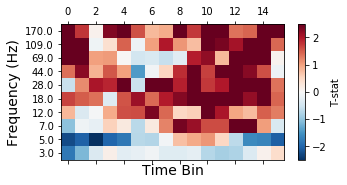

In [5]:
# Visualize results for one electrode
%matplotlib inline
import matplotlib.pyplot as plt

# Electrode 1 shows a classic tilt response,
# electrode 11 shows a theta response.
elec = 1
plt.figure(figsize=(5, 2.5))
ax = plt.subplot(111)
plt.matshow(tstats[:, elec, :], fignum=0, cmap='RdBu_r', aspect='auto', vmin=-2.5, vmax=2.5)
plt.yticks(np.arange(len(myfreqs)), np.round(myfreqs))
ax.invert_yaxis()
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
cb = plt.colorbar()
cb.set_label('T-stat')

channels = load.Load(df_select.iloc[0], 'channels')
print(channels.iloc[elec]['ind.region'])

Ttest_indResult(statistic=-2.5067252687493564, pvalue=0.012342128124738515)


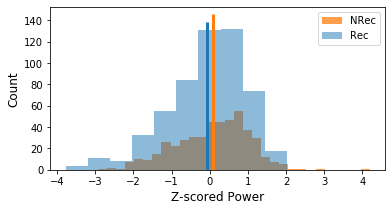

In [6]:
# Let's take a look at exactly what we were comparing
# by drilling down into one of the pixels from the plot above
freq_idx = 1  # 5Hz
time_idx = 2  # 200ms-300ms after word event

rec_pows = all_pows[freq_idx, recalled==1, elec, time_idx]
nrec_pows = all_pows[freq_idx, recalled==0, elec, time_idx]

plt.figure(figsize=(6, 3))
ax = plt.subplot(111)
plt.hist(nrec_pows, 30, alpha=0.75, label='NRec', color='C1')
plt.hist(rec_pows, alpha=0.5, label='Rec', color='C0');
plt.legend()
plt.vlines(np.mean(rec_pows), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='C0', linewidth=3)
plt.vlines(np.mean(nrec_pows), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], color='C1', linewidth=3)
plt.xlabel('Z-scored Power', fontsize=12)
plt.ylabel('Count', fontsize=12)

print(ttest_ind(rec_pows, nrec_pows, equal_var=False))

supramarginal


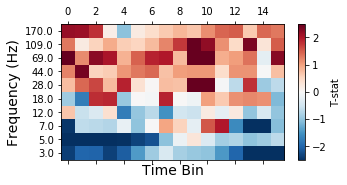

In [7]:
# Electrode 1 shows a classic tilt response,
# electrode 11 shows a theta response.
elec = 11
plt.figure(figsize=(5, 2.5))
ax = plt.subplot(111)
plt.matshow(tstats[:, elec, :], fignum=0, cmap='RdBu_r', aspect='auto', vmin=-2.5, vmax=2.5)
plt.yticks(np.arange(len(myfreqs)), np.round(myfreqs))
ax.invert_yaxis()
plt.xlabel('Time Bin', fontsize=14)
plt.ylabel('Frequency (Hz)', fontsize=14)
cb = plt.colorbar(); cb.set_label('T-stat')

print(channels.iloc[elec]['ind.region'])

**Exercise: Compute the SME for all electrodes in R1002P, and plot time-frequency spectrograms averaged across hippocampal electrodes**

**Exercise: Compute the SME for all electrodes in R1001P using MNE**